<a href="https://colab.research.google.com/github/nadya1462/sirius_2022/blob/main/Seminar_1_Introduction_to_Spiking_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 1. Introduction to Brian2

##Plan

* Units, neuron groups, ODE, monitoring, plots
* Input current and spike generators
* Modeling networks: synapses
* Modeling leaky integrate and fire (LIF) neurons
* Modeling integrate and fire neurons with adaptation

## Sources
Gerstner W., et.al. "Neuronal Dynamics" exercises using Brian2: https://neuronaldynamics-exercises.readthedocs.io/en/latest/

Brian2 docs: https://brian2.readthedocs.io

Brian2 tutorials: https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html

Brian1 --> Brian2 docs: https://brian2.readthedocs.io/en/stable/introduction/brian1_to_2/index.html

In [1]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import brian2 as b2

In [2]:
b2.start_scope() # clear the Brian scope (previous simulations info)

T = 50 * b2.ms # run time

# ODE: declares the variable & defines the equation
# The units must be SI (volts, second, amp, ect.)
eqs ='''
dv/dt = (v_rest-v)/tau : volt
tau : second
v_rest : volt
'''

G = b2.NeuronGroup(1, eqs, method = 'linear')
G.tau = 10 * b2.ms 
G.v_rest = -50 * b2.mvolt 
G.v = -65 * b2.mvolt

In [5]:
## 2nd var

b2.start_scope() # clear the Brian scope

tau = 10 * b2.ms # milliseconds
v_rest = -50 * b2.mvolt # millivolts
v0 = -65 * b2.mvolt
T = 100 * b2.ms

# ODE: declares the variable & defines the equation
# The units must be SI (volts, s, amp, ect.)
eqs ='''
dv/dt = (v_rest-v)/tau : volt
'''
G = b2.NeuronGroup(1, eqs, method = 'linear')
G.v = v0

In [6]:
v_mon = b2.StateMonitor(G, 'v', record=True)

print(f'Before v = {G.v[0]}')
b2.run(T)
print(f'After v = {G.v[0]}')

Before v = -65. mV
After v = -50.000681 mV


In [7]:
analitic_v = v_rest * (1 - b2.exp(-T/tau))
print(f'Expected value of v = {analitic_v}')

Expected value of v = -49.99773 mV


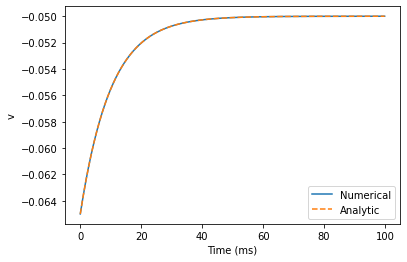

In [8]:
b2.plot(v_mon.t/b2.ms, v_mon.v[0], label = 'Numerical')
b2.plot(v_mon.t/b2.ms, v_rest + (v0 - v_rest) * b2.exp(-v_mon.t/tau), 'C1--', label = 'Analytic')
b2.xlabel('Time (ms)')
b2.ylabel('v')
b2.legend()

### Neurons
* input current
* spikes and reset
* refractoriness

https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html#adding-spikes

In [13]:
def plot_v(v_mon, v_threshold = None):
    plt.plot(v_mon.t/b2.ms, v_mon.v[0]/b2.mvolt, label = 'Membrane voltage')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    if v_threshold:
        plt.axhline(v_threshold/b2.mvolt, ls = '--', c = 'C2', label = 'Threshold') 
        
def plot_spikes(s_mon):
    for t in s_mon.t:
        b2.axvline(t/b2.ms, ls = '--', c = 'C1', lw = 3)

In [ ]:
b2.start_scope()

tau = 10 * b2.ms 
v_rest = -65 * b2.mvolt 
v0 = -65 * b2.mvolt
v_th = -35 * b2.mvolt
v_reset = -80 * b2.mvolt
R = 10 * b2.Mohm
I = 4 * b2.namp
T = 200 * b2.ms

eqs ='''
dv/dt = (v_rest-v)/tau + R*I/tau: volt
'''
G = b2.NeuronGroup(1, eqs,
                   threshold = 'v > v_th', 
                   reset = 'v = v_reset', 
                   method = 'exact')
G.v = v0

v_mon = b2.StateMonitor(G, 'v', record=True)
spike_mon = b2.SpikeMonitor(G)

b2.run(T)

Spike times: [ 13.8  30.9  48.   65.1  82.2  99.3 116.4 133.5 150.6 167.7 184.8] ms
Frequency: 55. Hz


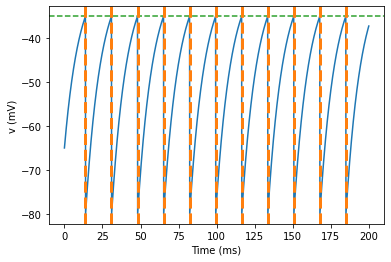

In [49]:
print(f'Spike times: {spike_mon.t[:]}')
print(f'Frequency: {spike_mon.count[0]/T}')

plot_v(v_mon, v_th)
plot_spikes(spike_mon)

### Refractoriness
After a spike the neuron enters the refractory period and cannot fire new spikes.

Spike times: [  0.  22.  44.  66.  88. 110. 132. 154. 176. 198.] ms
Frequency: 50. Hz


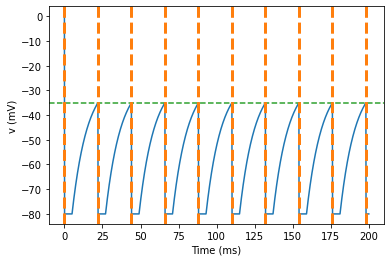

In [ ]:
b2.start_scope()

tau_ref = 5 * b2.ms # add refractory period

eqs ='''
dv/dt = (v_rest-v)/tau + R*I/tau: volt (unless refractory)
'''
G = b2.NeuronGroup(1, eqs,
                   threshold = 'v>v_th', 
                   reset = 'v = v_reset',
                   refractory = tau_ref,
                   method = 'exact')

v_mon = b2.StateMonitor(G, 'v', record = True)
spike_mon = b2.SpikeMonitor(G)

b2.run(T)

In [ ]:
print(f'Spike times: {spike_mon.t[:]}')
print(f'Frequency: {spike_mon.count[0]/T}')

plot_v(v_mon, v_th)
plot_spikes(spike_mon)

### Time-dependent input
Here is the example of step current with increasing amplitute

#### Exercise 1
Explore how the spiking frequency of a LIF neuron depends on the amplitude of the step current. 
Plot I-f curve where current is along x-axis and frequency is along y-axis

#### Exercise 2
Implement sinusoidal current and see how the neuron reacts. Print the spiking frequency

In [ ]:
def plot_I(v_mon, current):
    plt.xlabel('Time (ms)')
    plt.ylabel('I (nA)')
    plt.plot(v_mon.t/b2.ms, current(v_mon.t)/b2.namp, 'r', lw = 2, label = 'Input current')   

In [23]:
b2.start_scope()

R = 10 * b2.Mohm # membrane resistance 
tau = 10 * b2.ms # membrane time scale
v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential
T = 800 * b2.ms # simulation time

# Create input current
I_subthres = 1.45
I_low = 1.55
I_high = 2.5

#Step input
I_arr = [0]*5 + [I_subthres]*20 + [I_low]*20 + [I_high]*20 + [0]
I = b2.TimedArray(I_arr * b2.namp, dt = 10 * b2.ms)

# Periodic input
# ?

eqs ='''
dv/dt = (v_rest-v)/tau + R*I(t)/tau : volt
'''
G = b2.NeuronGroup(1, eqs,
                   threshold = 'v > v_th', 
                   reset = 'v = v_reset', 
                   method = 'linear')
G.v = v0

v_mon = b2.StateMonitor(G, 'v', record = True)
spike_mon = b2.SpikeMonitor(G)

b2.run(T)

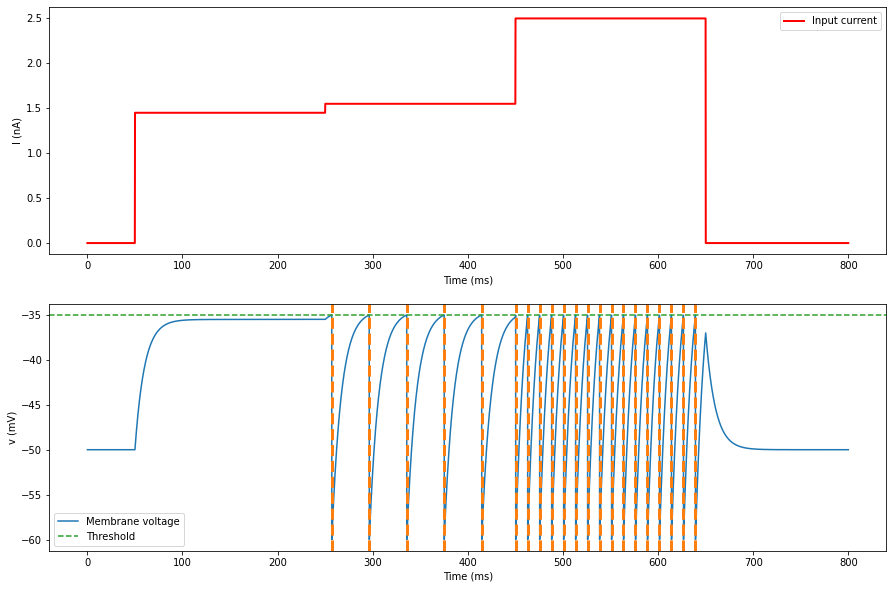

In [34]:
plt.figure(figsize = (15, 10))

plt.subplot(2,1,1)
plot_I(v_mon, I)
plt.legend()

plt.subplot(2,1,2)
plot_v(v_mon, v_th)
plot_spikes(spike_mon)
plt.legend()

### Synapses in Brian2
https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html

WARNING    'tau' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v_rest' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


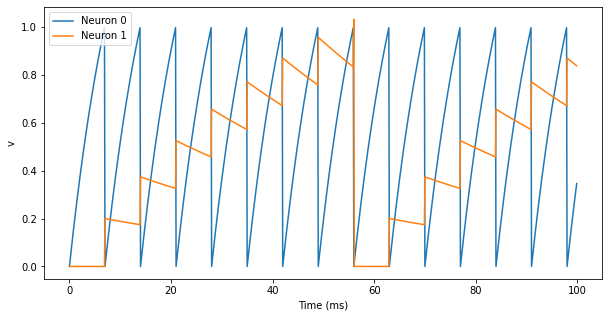

In [36]:
b2.start_scope()

eqs = '''
dv/dt = (v_rest - v) / tau : 1
v_rest : 1
tau : second
'''
G = b2.NeuronGroup(2, eqs, threshold = 'v > 1', reset = 'v = 0', method = 'exact')
G.v_rest = [2, 0]
G.tau = [10, 50] * b2.ms

S = b2.Synapses(G, G, on_pre = 'v_post += 0.2')
# S_inh = b2.Synapses(G, G, on_pre = 'v_post -= 0.3')
S.connect(i=0, j=1)

v_mon = b2.StateMonitor(G, 'v', record = True)

b2.run(100 * b2.ms)

plt.figure(figsize = (10, 5))
plt.plot(v_mon.t/b2.ms, v_mon.v[0], label = 'Neuron 0')
plt.plot(v_mon.t/b2.ms, v_mon.v[1], label = 'Neuron 1')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend()

### LIF with threshold adaptation
Example from Brian2 tutorials:
https://brian2.readthedocs.io/en/stable/examples/adaptive_threshold.html

New input object: SpikeGenerator

Excersise: plot I-f curve for Adaptive LIF neuron

In [42]:
b2.start_scope()

eqs = '''
dv/dt = -v / tau_v : volt
dv_th/dt = (v_th_0 - v_th) / tau_th : volt
tau_v : second
tau_th : second
v_reset : volt
theta : volt
'''
reset = '''
v = v_reset
v_th += theta
'''
IF = b2.NeuronGroup(1, model = eqs, reset = reset, threshold = 'v > v_th', method = 'exact')
IF.v_th = 10 * b2.mV
IF.tau_v = 10 * b2.ms
IF.tau_th = 15 * b2.ms
IF.v_reset = 0 * b2.mV
IF.theta = 3 * b2.mV

PG = b2.PoissonGroup(1, 500 * b2.Hz)

w_syn = 3 * b2.mV
C = b2.Synapses(PG, IF, on_pre = 'v += w_syn')
C.connect()

Mv = b2.StateMonitor(IF, 'v', record = True)
Mv_th = b2.StateMonitor(IF, 'v_th', record = True)
# Record the value of v when the threshold is crossed
M_crossings = b2.SpikeMonitor(IF, 'v')
b2.run(0.5 * b2.second) 

WARNING    'tau_th' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 15. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_v' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v_th' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value -35. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'theta' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 3. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v_reset' is an internal variable of group 'neurongroup_6', but also exists in th

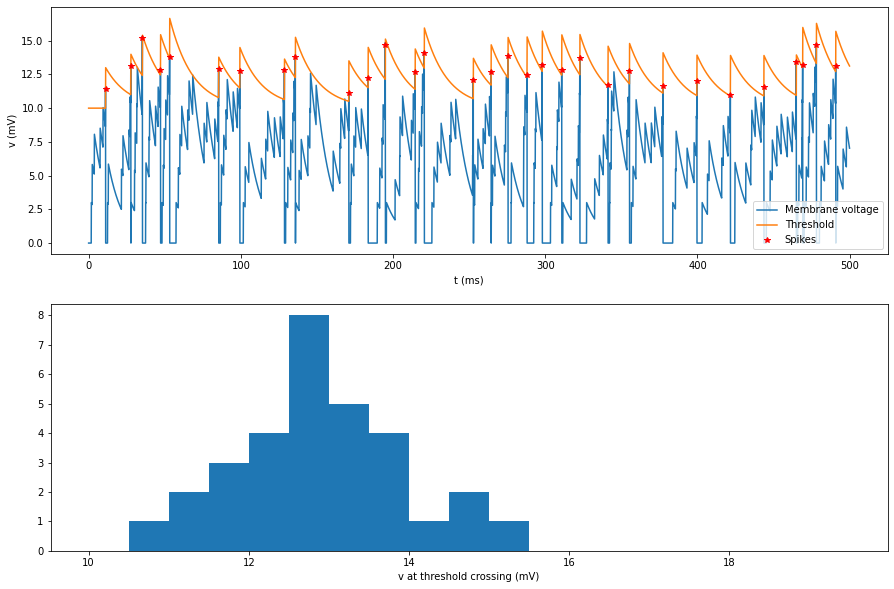

In [43]:
b2.figure(figsize = (15, 10))

b2.subplot(2, 1, 1)
b2.plot(Mv.t/b2.ms, Mv[0].v/b2.mV, label = 'Membrane voltage')
b2.plot(Mv_th.t/b2.ms, Mv_th[0].v_th/b2.mV, label = 'Threshold')
b2.plot(M_crossings.t/b2.ms, M_crossings.v/b2.mV, '*r', label = 'Spikes')
b2.legend()
b2.ylabel('v (mV)')
b2.xlabel('t (ms)')
# zoom in on the first 100ms
# b2.xlim(0, 100)

b2.subplot(2, 1, 2)
b2.hist(M_crossings.v/b2.mV, bins = np.arange(10, 20, 0.5))
b2.xlabel('v at threshold crossing (mV)')
b2.show()

### Mutual inhibition
A simple network where two neurons inhibit each other and oscillate in anti-phase

#### Excercise
Add threshold adaptaion to the neurons as in the cell above.
Make the neurons fire not a single spike, but spike bursts in anti-phase.

About "connect":
https://brian2.readthedocs.io/en/stable/reference/brian2.synapses.synapses.Synapses.html?highlight=connect

In [ ]:
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize = (12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label = 'left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label = 'right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend()

    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms, s_mon.i/1, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num')   

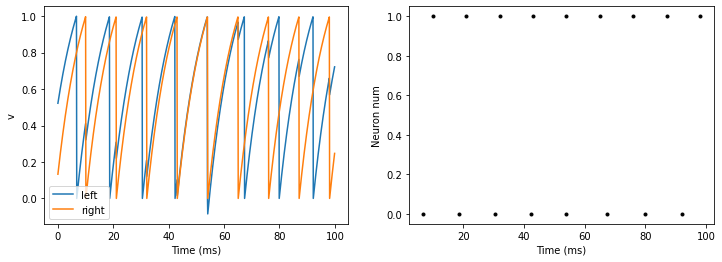

In [41]:
b2.start_scope()

eqs = '''
dv/dt = (I - v) / tau : 1
tau : second
v_th : 1
I : 1
'''
G = b2.NeuronGroup(2, eqs, threshold = 'v > v_th', reset = 'v = 0', method = 'linear')
G.v = 'rand()'
G.v_th = 1
G.I = 1.5
G.tau = [10, 10] * b2.ms

w_syn = -0.1
S = b2.Synapses(G, G, on_pre = 'v += w_syn')
S.connect(i = [0, 1], j = [1, 0])
# S.connect('i != j') # equal to previous

v_mon = b2.StateMonitor(G, 'v', record = True)
s_mon = b2.SpikeMonitor(G)

net = b2.Network(G, S, v_mon, s_mon)
net.run(100 * b2.ms)

plot_v_spikes(v_mon, s_mon)

## Homework
### Excersise 1 (Simple pattern recognition)
Here we model an "artificial retina" which is able to detect orientation of the presented bars. 
The input is a 3x3 matrix I where I(i,j) is the light intensity at the point with coordinates (i,j):

* Create a two-layer network where first layer is "receptor" neurons which transforms the I(i,j) input to the spike frequency. 
* Each neuron of the second layer receives 9 inputs from each "receptor". 
* Each neuron should encode one orientation: vertical, horizontal, diagonal.

### Excercise 2 (Population coding)
Modify the previous example such that the orientation is encoded by the frequency of total neural activity 